# Berlin bike theft 

possible for parameterization: `date`, `type of theft`, `location`

In [1]:
import os
import pandas as pd

In [50]:
# import data
# !wget -O 2023-03-16_berlin-bike-theft.csv "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"
# !wget -O 2023-03-17_berlin-bike-theft.csv "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"

# read data

In [9]:
# def custom_date_parser(date_str):
#     return pd.to_datetime(date_str, format='%d.%m.%Y %H')

# bike_theft_df = pd.read_csv(
#     '2023-03-17_berlin-bike-theft.csv',
#     encoding='latin-1',
#     parse_dates={
#         'ANGELEGT_DATUM'   : ['ANGELEGT_AM'],
#         'TATZEIT_ANFANG': ['TATZEIT_ANFANG_DATUM', 'TATZEIT_ANFANG_STUNDE'], 
#         'TATZEIT_ENDE'  : ['TATZEIT_ENDE_DATUM', 'TATZEIT_ENDE_STUNDE']
#     },
#     date_parser=custom_date_parser)

bike_theft_df = pd.read_csv(
    'data/raw/2023-03-29_berlin-bike-theft.csv',
    encoding='latin-1',
    parse_dates=['ANGELEGT_AM', 'TATZEIT_ANFANG_DATUM', 'TATZEIT_ENDE_DATUM'],
    dayfirst=True)

## explore

In [10]:
# bike_theft_df.info()
bike_theft_df.dtypes

ANGELEGT_AM              datetime64[ns]
TATZEIT_ANFANG_DATUM     datetime64[ns]
TATZEIT_ANFANG_STUNDE             int64
TATZEIT_ENDE_DATUM       datetime64[ns]
TATZEIT_ENDE_STUNDE               int64
LOR                               int64
SCHADENSHOEHE                     int64
VERSUCH                          object
ART_DES_FAHRRADS                 object
DELIKT                           object
ERFASSUNGSGRUND                  object
dtype: object

In [12]:
# get max date as date with format YYYY-MM-DD
date_download = "2023-03-29"
date_last_entry = bike_theft_df['ANGELEGT_AM'].max().date().isoformat()

print(f"Download Date: {date_download}")
print(f"Date Newest Entry: {date_last_entry}")

Download Date: 2023-03-29
Date Newest Entry: 2023-03-28


## transform

In [13]:
# combine TATZEIT_DATUM and TATZEIT_STUNDE to create TATZEIT
bike_theft_df['TATZEIT_ANFANG'] = bike_theft_df['TATZEIT_ANFANG_DATUM'] + pd.to_timedelta(bike_theft_df['TATZEIT_ANFANG_STUNDE'], unit='h')
bike_theft_df['TATZEIT_ENDE'] = bike_theft_df['TATZEIT_ENDE_DATUM'] + pd.to_timedelta(bike_theft_df['TATZEIT_ENDE_STUNDE'], unit='h')

# extract hour from TATZEIT_ANFANG and assign it to TATZEIT_ANFANG_STUNDE
bike_theft_df['TATZEIT_ANFANG_STUNDE'] = bike_theft_df['TATZEIT_ANFANG'].dt.hour
bike_theft_df['TATZEIT_ENDE_STUNDE'] = bike_theft_df['TATZEIT_ENDE'].dt.hour

# generate tatzeit dauer
bike_theft_df['TATZEIT_DAUER'] = (bike_theft_df['TATZEIT_ENDE'] - bike_theft_df['TATZEIT_ANFANG']) / pd.Timedelta(hours=1)


In [14]:
bike_theft_df.head()

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND,TATZEIT_ANFANG,TATZEIT_ENDE,TATZEIT_DAUER
0,2023-03-28,2023-03-27,19,2023-03-28,7,3701555,910,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-03-27 19:00:00,2023-03-28 07:00:00,12.0
1,2023-03-28,2023-03-26,12,2023-03-26,19,11200410,459,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-03-26 12:00:00,2023-03-26 19:00:00,7.0
2,2023-03-28,2023-03-27,19,2023-03-28,8,2400521,1320,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-03-27 19:00:00,2023-03-28 08:00:00,13.0
3,2023-03-28,2023-03-27,21,2023-03-28,14,12500926,900,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-03-27 21:00:00,2023-03-28 14:00:00,17.0
4,2023-03-28,2023-03-25,19,2023-03-26,9,2300315,340,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-03-25 19:00:00,2023-03-26 09:00:00,14.0


## visualize

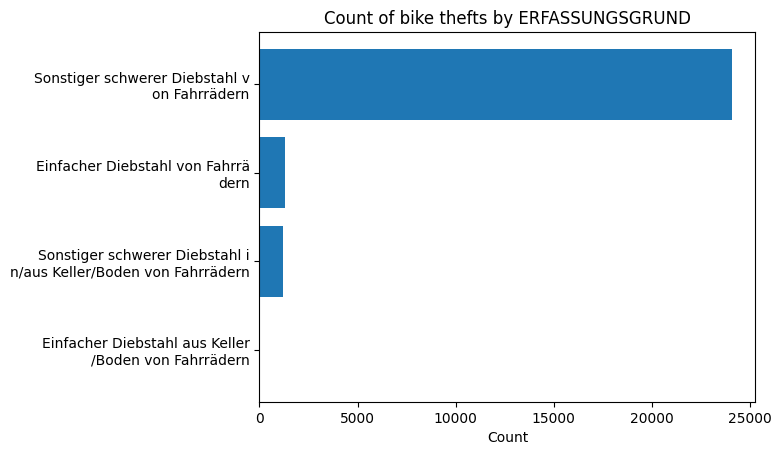

In [15]:
import matplotlib.pyplot as plt

counts = bike_theft_df['ERFASSUNGSGRUND'].value_counts().sort_values(ascending=True)
labels = [f'{s[:30]}\n{s[30:]}' if len(s) > 30 else s for s in counts.index]
plt.barh(labels, counts.values)
plt.xlabel('Count')
plt.title('Count of bike thefts by ERFASSUNGSGRUND')
plt.show()

## export to pq

In [17]:
# export bike_theft_df as parquet woth TODAY ad prefix in the filename
bike_theft_df.to_parquet(f'data/pq/{date_download}_berlin-bike-theft.parquet', index=False)

In [21]:
from pathlib import Path
import os

local_prefix = Path(f"data/raw")

most_recent_date = max([file.split('_')[0] for file in os.listdir(local_prefix)])

print(most_recent_date)

2023-04-04


In [27]:

from prefect_gcp.cloud_storage import GcsBucket     # to upload to GCS
from prefect_gcp.cloud_storage import GcsBucket

gcs_bucket = GcsBucket.load("de-zoomcamp-gcs")
gcs_bucket.read_path(local_prefix)



AttributeError: 'coroutine' object has no attribute 'read_path'